In [1]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import torchvision
import time
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from sklearn.metrics import confusion_matrix
import pandas as pd
import os

In [2]:
def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
#         print(images.shape)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

In [3]:
def transform(dataset):
    data_transform = transforms.Compose([transforms.Resize((299,299)),transforms.ToTensor()])
    data_set=torchvision.datasets.ImageFolder(root=dataset,transform=data_transform)
    data_loader=torch.utils.data.DataLoader(dataset=data_set,batch_size=32,shuffle=True)
    mean,std=get_mean_std(data_loader)
    data_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    data_set=torchvision.datasets.ImageFolder(root=dataset,transform=data_transform)
    data_loader=torch.utils.data.DataLoader(dataset=data_set,batch_size=64,shuffle=True,drop_last=False,num_workers=0)
    return data_loader,data_set

In [4]:
train_dataset='../Datasets/dataset_2_classes/train/'
train_loader,training_dataset=transform(train_dataset)

In [5]:
validate_dataset='../Datasets/dataset_2_classes/validate/'
validate_loader,validating_dataset=transform(validate_dataset)

In [6]:
test_dataset='../Datasets/dataset_2_classes/test/'
test_loader,testing_dataset=transform(test_dataset)

In [7]:
def set_device():
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    return device

In [8]:
device=set_device()

In [9]:
def get_model():
    model = models.inception_v3(pretrained=False)
    for param in model.parameters():
        param.requires_grad = False #Freezing all the layers and changing only the below layers
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(2048,128),
                            nn.ReLU(),
                            nn.Linear(128,2))
    model.aux_logits = False
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,momentum=0.9)
    return model.to(device), criterion, optimizer

In [10]:
model, criterion, optimizer = get_model()

/Users/bhanuprakash/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bhanuprakash/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/bhanuprakash/miniforge3/lib/python3.10/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [11]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0001)

In [12]:
n_epochs = 50
epoch_count = 0
Accuracies = [] 
valAccuracies = []
valLoss = []
trainLoss = []
validation_accuracy = 0

In [13]:
for epoch in range(n_epochs):
    print("Epoch: %d "%(epoch+1))
    model.train()
    running_loss=0.0
    running_correct=0.0
    val_loss=0.0
    total=0
    t1 = time.time()
    for i,data in enumerate(train_loader):
        images,labels=data
        images=images.to(device)
        labels=labels.to(device)
        total+=labels.size(0)
        optimizer.zero_grad()
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        running_correct+=(labels==predicted).sum().item()
        traning_accuracy=(running_correct/total)*100
    
    validation_accuracy=0
    model.eval()
    with torch.no_grad():
        val_correct=0
        val_total=0
        val_loss=0
        for data in validate_loader:
            images,val_labels=data[0].to(device), data[1].to(device)
            images = images.to(device)
            val_labels = val_labels.to(device)
            outputs=model(images)
            loss_val=criterion(outputs,val_labels)
            val_loss+= loss_val.item()
            _,predicted=torch.max(outputs.data,1)
            val_correct+=(predicted == val_labels).sum().item()
            val_total+=val_labels.size(0)
        validation_accuracy = (val_correct / val_total) *100
    
    scheduler.step()
    epoch_loss=running_loss/len(train_loader)
    val_loss=val_loss/len(validate_loader)
    epoch_accuracy=100.00* running_correct/total
    Accuracies.append(epoch_accuracy)
    valAccuracies.append(validation_accuracy)
    trainLoss.append(epoch_loss)
    valLoss.append(val_loss)
    print("######## epoch Finished in {} seconds ###########".format(time.time()\
                                                                    -t1))
    print("Training Data: Epoch Loss: %.3f, Epoch Accuracy: %.3f, Validation Loss: %.3f,Validation Accuracy: %.3f"%(epoch_loss,epoch_accuracy,val_loss,validation_accuracy))
    
        

Epoch: 1 
######## epoch Finished in 15.699548244476318 seconds ###########
Training Data: Epoch Loss: 0.588, Epoch Accuracy: 79.102, Validation Loss: 1.322,Validation Accuracy: 72.948
Epoch: 2 
######## epoch Finished in 15.911890268325806 seconds ###########
Training Data: Epoch Loss: 0.502, Epoch Accuracy: 81.152, Validation Loss: 0.609,Validation Accuracy: 72.948
Epoch: 3 
######## epoch Finished in 15.363548994064331 seconds ###########
Training Data: Epoch Loss: 0.460, Epoch Accuracy: 81.348, Validation Loss: 0.564,Validation Accuracy: 72.492
Epoch: 4 
######## epoch Finished in 15.370973825454712 seconds ###########
Training Data: Epoch Loss: 0.443, Epoch Accuracy: 81.543, Validation Loss: 0.572,Validation Accuracy: 72.644
Epoch: 5 
######## epoch Finished in 15.52700424194336 seconds ###########
Training Data: Epoch Loss: 0.439, Epoch Accuracy: 81.836, Validation Loss: 0.580,Validation Accuracy: 73.252
Epoch: 6 
######## epoch Finished in 15.502807140350342 seconds ###########


######## epoch Finished in 15.427335023880005 seconds ###########
Training Data: Epoch Loss: 0.258, Epoch Accuracy: 90.137, Validation Loss: 0.396,Validation Accuracy: 82.067
Epoch: 47 
######## epoch Finished in 15.495130062103271 seconds ###########
Training Data: Epoch Loss: 0.245, Epoch Accuracy: 90.625, Validation Loss: 0.398,Validation Accuracy: 81.307
Epoch: 48 
######## epoch Finished in 15.36607313156128 seconds ###########
Training Data: Epoch Loss: 0.246, Epoch Accuracy: 89.160, Validation Loss: 0.400,Validation Accuracy: 82.827
Epoch: 49 
######## epoch Finished in 15.333741188049316 seconds ###########
Training Data: Epoch Loss: 0.253, Epoch Accuracy: 90.430, Validation Loss: 0.369,Validation Accuracy: 83.739
Epoch: 50 
######## epoch Finished in 15.498438119888306 seconds ###########
Training Data: Epoch Loss: 0.244, Epoch Accuracy: 90.918, Validation Loss: 0.371,Validation Accuracy: 83.739


In [14]:
print("---Training finished in {} seconds---".format(time.time()-t1))
epoch_count+=n_epochs
torch.save(model.state_dict(), "2-Class-InceptionV3-"+str(epoch_count)+"-epoch.pt")

---Training finished in 15.502909183502197 seconds---


In [15]:
def evaluate_model(model,test_loader):
    model.eval()
    predicted_correct =0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total+=labels.size(0)
            outputs = model(images)
            _,predicted = torch.max(outputs,1)
            predicted_correct += (predicted == labels).sum().item()
    epoch_accuracy = 100.0* predicted_correct/total
    print("Testing Data: Epoch Accuracy: %.3f"%(epoch_accuracy))
    return epoch_accuracy

In [16]:
evaluate_model(model,test_loader)

Testing Data: Epoch Accuracy: 79.833


79.83333333333333

In [17]:
dict = {'Training': Accuracies, 'Validation': valAccuracies} 
dictLoss = {'Training': trainLoss,'Validation': valLoss}
df = pd.DataFrame(dict)
df2 = pd.DataFrame(dictLoss)
df.to_csv("Accuracies_InceptionV3_2classes"+str(epoch_count)+".csv")
df2.to_csv("Loss_InceptionV3_2classes"+str(epoch_count)+".csv")

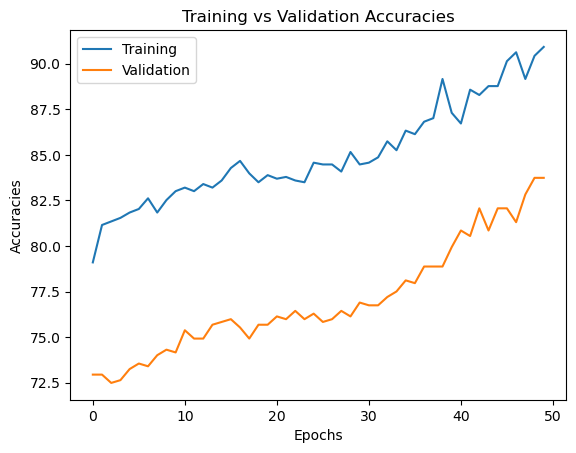

In [18]:
plt.plot(range(n_epochs),Accuracies, label="Training")
plt.plot(range(n_epochs),valAccuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Training vs Validation Accuracies")
plt.legend()
plt.show()

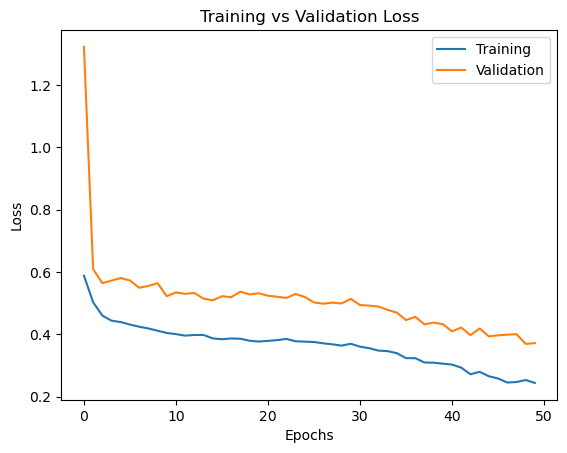

In [19]:
plt.plot(range(n_epochs),trainLoss, label="Training")
plt.plot(range(n_epochs),valLoss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay

In [21]:
y_pred = []
y_true = []

for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs) 
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

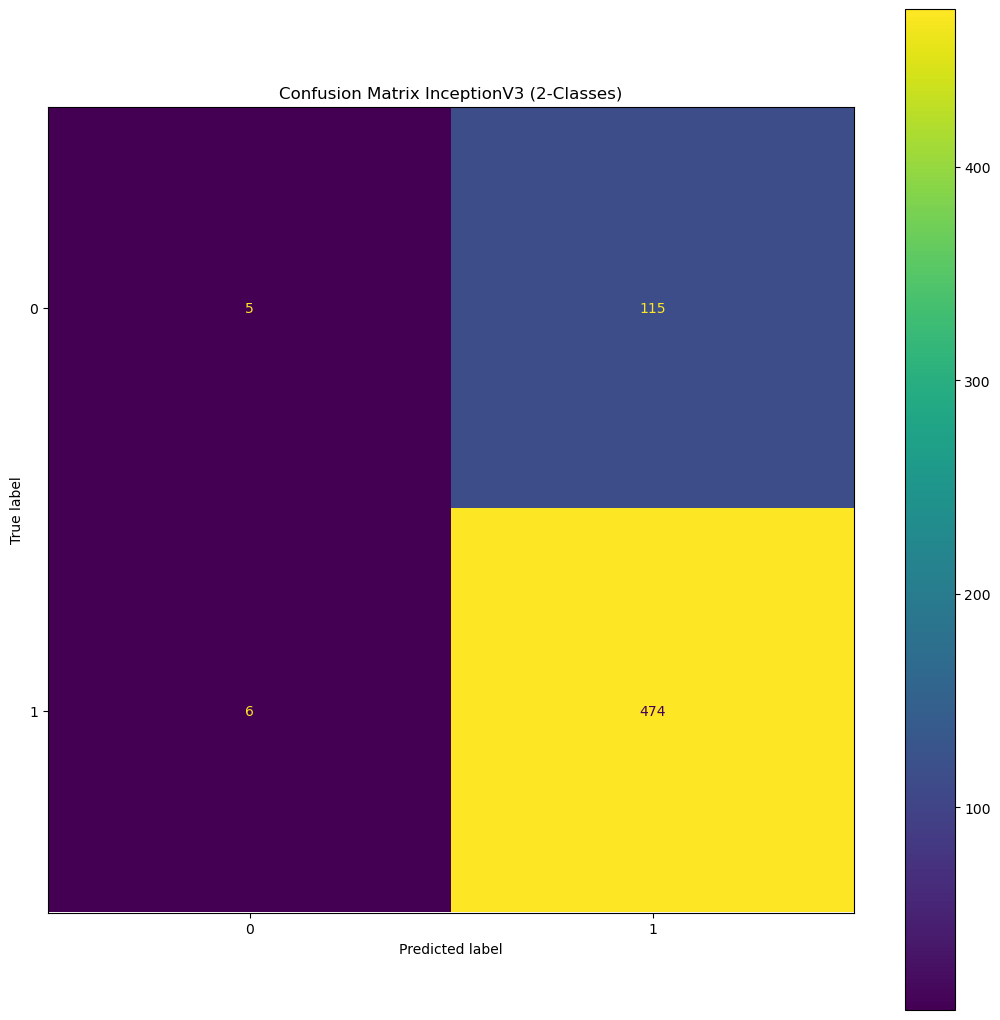

In [22]:
classes = (0,1)
confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),display_labels=classes)
fig,ax = plt.subplots()
fig.set_size_inches(13,13)
plt.title("Confusion Matrix InceptionV3 (2-Classes)")
disp.plot(ax=ax)
plt.show()

In [23]:
print("Precision Macro:{:.2f}".format(precision_score(y_true, y_pred, average='macro')))
print("Precision Micro:{:.2f}".format(precision_score(y_true,y_pred,average='micro')))
print("Recall Macro:{:.2f}".format(recall_score(y_true,y_pred,average='macro')))
print("Recall Micro:{:.2f}".format(recall_score(y_true,y_pred,average='micro')))
print("F1-Score Macro:{:.2f}".format(f1_score(y_true,y_pred,average='macro')))
print("F1-Score Micro:{:.2f}".format(f1_score(y_true,y_pred,average='micro')))

Precision Macro:0.63
Precision Micro:0.80
Recall Macro:0.51
Recall Micro:0.80
F1-Score Macro:0.48
F1-Score Micro:0.80
